In [72]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget
%pdb off

from pyCascade import probePost, physics, utils, probeReadWrite
from matplotlib import pyplot as plt
from matplotlib import cm, colors
import numpy as np
import scipy as sp
import os
from IPython.core.debugger import set_trace
import pandas as pd
import seaborn as sns
from fnmatch import fnmatch
from cycler import cycler

plt.rcParams['figure.dpi'] = 140
im_scaling = .75
plt.rcParams['figure.figsize'] = [6.4 * im_scaling, 4.8 * im_scaling]

category =  "config2"

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)
plt.close('all')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Automatic pdb calling has been turned OFF


'/scratch/users/nbachand/Cascade/city_block_cfd'

'/home/users/nbachand/Cascade/city_block_cfd'

In [73]:
hm = 6
window_dim = hm/2/4
velTenMeters = 4

velocity_scaling = 1/velTenMeters
ventilation_scaling = velocity_scaling/(window_dim**2)

@utils.no_kwargs
@utils.dict_apply
def norm_vel(df):
    return df * velocity_scaling

@utils.no_kwargs
@utils.dict_apply
def norm_vent(df):
    return df * ventilation_scaling

@utils.no_kwargs
@utils.dict_apply
def abs_values(df):
    return df.abs()

@utils.no_kwargs
@utils.dict_apply
def flip_data(df):
    return -df


In [74]:
qoisOutputed = ["mass_flux", "comp(u,0)"]
qois= ["mass_flux"]

In [75]:
runs = {
    15: {'B': False, 'A': 0,  'WS': 4},
    16: {'B': False, 'A': 45, 'WS': 4},
    17: {'B': False, 'A': 0,  'WS': 2},
    21: {'B': True,  'A': 0,  'WS': 4},
    22: {'B': False, 'A': 45, 'WS': 2},
    23: {'B': True,  'A': 0,  'WS': 2},
    24: {'B': True,  'A': 45, 'WS': 2},
    # 25: {'B': True,  'A': 45, 'WS': 4},
}


In [76]:
start = 40000
stop = -1
by = 1

In [77]:
roomQois = ["mean", "net"]

connectedWindows = {
    "corner": [
        "xwindow_0-0",
        "zwindow_0-0",
        "skylight_0-0"
    ],
    "single": [
        "zwindow_1-0",
        "skylight_1-0"
    ],
    "dual": [
        "xwindow_0-1",
        "zwindow_0-1",
        "zwindow_1-1",
        "skylight_0-1",
        "skylight_1-1"
       ],
    "cross": [
        "zwindow_2-0",
        "zwindow_2-1",
        "skylight_2-0",
        "skylight_2-1"
    ]
}


In [78]:
allFlowStats = {}
allRoomVentilation = {}
overwrite = False
for i, run in enumerate(runs):
    probes_dir = f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut'
    print(probes_dir)
    flowStatsPath = f"{probes_dir}/../flowStats.csv"
    roomVentilationPath = f"{probes_dir}/../roomVentiation.csv"
    if os.path.exists(roomVentilationPath) and os.path.exists(flowStatsPath) and overwrite == False:
        roomVentilation = pd.read_csv(roomVentilationPath, index_col=0)
        flowStats = pd.read_csv(flowStatsPath, index_col=0)
    else:
        probes = probePost.Probes(probes_dir, probe_type = "FLUX_PROBES", flux_quants = qoisOutputed, file_type = "parquet")
        plt.plot(probes.probe_steps, probes.probe_times)

        ## X Flow

        @utils.no_kwargs
        def norm_norm_blocks(data_dict):
            if category == "config2":
                return probePost.mul_names(data_dict, [name for name in probes.probe_names if "Bxz" in name or "Bz" in name], -1)
            return data_dict

        ## mean statistics
        x_mean = probes.statistics(
            names = [name for name in  probes.probe_names if "xwindow" in name], 
            steps = probes.probe_steps[start:stop:by],
            quants = qois,
            processing = [norm_vent, probePost.time_average, norm_norm_blocks],
            parrallel=False
            )

        ## rms statistics
        x_rms = probes.statistics(
            names = [name for name in  probes.probe_names if "xwindow" in name], 
            steps = probes.probe_steps[start:stop:by],
            quants = qois,
            processing = [norm_vent, probePost.time_rms],
            parrallel=False
            )

        ## Net flow
        x_net = probes.statistics(
            names = [name for name in  probes.probe_names if "xwindow" in name], 
            steps = probes.probe_steps[start:stop:by],
            quants = qois,
            processing = [norm_vent, abs_values, probePost.time_average],
            parrallel=False
            )

        x_flowStats = pd.concat([x_mean, x_rms, x_net], axis = "index").T
        x_flowStats.columns = ["mean", "rms", "net"]

        ## Z Flow

        @utils.no_kwargs
        def norm_norm_windows(data_dict):
            return probePost.mul_names(data_dict, [name for name in probes.probe_names if fnmatch(name, "*window_?-1*")], -1)

        @utils.no_kwargs
        def norm_norm_blocks(data_dict):
            if category == "config2":
                return probePost.mul_names(data_dict, [name for name in probes.probe_names if "Bxz" in name or "Bx" in name], -1)
            return data_dict

        ## mean statistics
        z_mean = probes.statistics(
            names = [name for name in  probes.probe_names if "zwindow" in name], 
            steps = probes.probe_steps[start:stop:by],
            quants = qois,
            processing = [norm_vent, probePost.time_average, norm_norm_windows, norm_norm_blocks],
            parrallel=False
            )

        ## rms statistics
        z_rms = probes.statistics(
            names = [name for name in  probes.probe_names if "zwindow" in name], 
            steps = probes.probe_steps[start:stop:by],
            quants = qois,
            processing = [norm_vent, probePost.time_rms],
            parrallel=False
            )

        ## Net flow
        z_net = probes.statistics(
            names = [name for name in  probes.probe_names if "zwindow" in name], 
            steps = probes.probe_steps[start:stop:by],
            quants = qois,
            processing = [norm_vent, abs_values, probePost.time_average],
            parrallel=False
            )

        z_flowStats = pd.concat([z_mean, z_rms, z_net], axis = "index").T
        z_flowStats.columns = ["mean", "rms", "net"]
        ## Y Flow

        ## mean statistics
        y_mean = probes.statistics(
            names = [name for name in  probes.probe_names if "skylight" in name], 
            steps = probes.probe_steps[start:stop:by],
            quants = qois,
            processing = [norm_vent, probePost.time_average, flip_data],
            parrallel=False
            )

        ## rms statistics
        y_rms = probes.statistics(
            names = [name for name in  probes.probe_names if "skylight" in name], 
            steps = probes.probe_steps[start:stop:by],
            quants = qois,
            processing = [norm_vent, probePost.time_rms],
            parrallel=False
            )

        ## Net flow
        y_net = probes.statistics(
            names = [name for name in  probes.probe_names if "skylight" in name], 
            steps = probes.probe_steps[start:stop:by],
            quants = qois,
            processing = [norm_vent, abs_values, probePost.time_average],
            parrallel=False
            )

        y_flowStats = pd.concat([y_mean, y_rms, y_net], axis = "index").T
        y_flowStats.columns = ["mean", "rms", "net"]
        ## All Flow
        flowStats = pd.concat([x_flowStats, y_flowStats, z_flowStats], axis = "index")
        flowStats = probePost.addWindowDetails(flowStats, probes.get_avg_locations(), probes.areas)

        sort_order = ["blockType", "houseType", "roomType"]
        roomVentilation = probePost.roomStatistics(flowStats, connectedWindows, roomQois)
        roomVentilation = roomVentilation.sort_values(by = sort_order)
        sort_order.append("windowType")
        flowStats = flowStats.sort_values(by = sort_order)
        display(roomVentilation)
        flowStats
        
        flowStats.to_csv(flowStatsPath)
        roomVentilation.to_csv(roomVentilationPath)
        probes = None
    allFlowStats[run] = flowStats
    allRoomVentilation[run] = roomVentilation


/scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config2/R15/probes/probesOut
/scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config2/R16/probes/probesOut
/scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config2/R17/probes/probesOut
/scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config2/R21/probes/probesOut
/scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config2/R22/probes/probesOut
/scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config2/R23/probes/probesOut
/scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config2/R24/probes/probesOut


In [79]:
flowStatsMI = pd.concat(allFlowStats.values(), keys=allFlowStats.keys())
roomVentilationMI = pd.concat(allRoomVentilation.values(), keys=allRoomVentilation.keys())

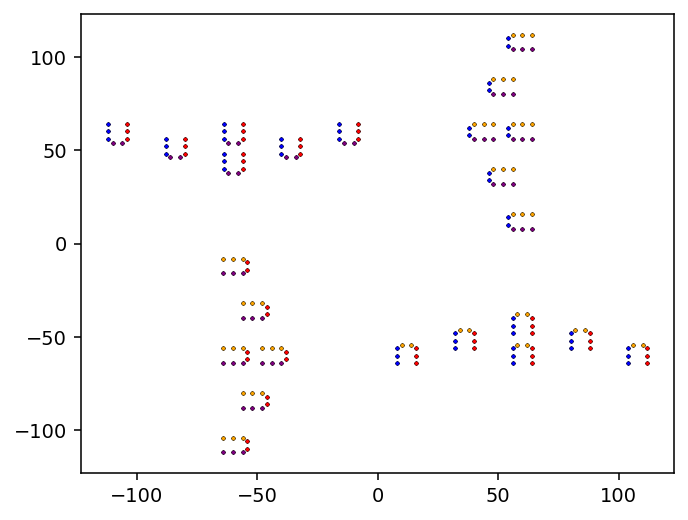

In [80]:
flowStatsMI["orientation"] = pd.Series(dtype=float)

flowStatsMI.loc[(
        (flowStatsMI.openingType == "xwindow") & (
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '[!0]-?'))) & (flowStatsMI.blockType.isna()) | 
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '0-?'))) & (flowStatsMI.blockType == "Bxz"))
    ) | (
        (flowStatsMI.openingType == "zwindow") & (
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '?-0'))) & (flowStatsMI.blockType == "Bx") | 
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '?-[!0]'))) & (flowStatsMI.blockType == "Bz"))
    ), "orientation"] = 0

flowStatsMI.loc[(
        (flowStatsMI.openingType == "xwindow") & (
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '0-?'))) & (flowStatsMI.blockType.isna()) | 
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '[!0]-?'))) & (flowStatsMI.blockType == "Bxz"))
    ) | (
        (flowStatsMI.openingType == "zwindow") & (
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '?-[!0]'))) & (flowStatsMI.blockType == "Bx") | 
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '?-0'))) & (flowStatsMI.blockType == "Bz"))
    ), "orientation"] = 180

flowStatsMI.loc[(
        (flowStatsMI.openingType == "xwindow") & (
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '[!0]-?'))) & (flowStatsMI.blockType == "Bx") | 
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '0-?'))) & (flowStatsMI.blockType == "Bz"))
    ) | (                                                                             
        (flowStatsMI.openingType == "zwindow") & (                                    
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '?-0'))) & (flowStatsMI.blockType == "Bxz") |
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '?-[!0]')))& (flowStatsMI.blockType.isna()))
    ), "orientation"] = 90

flowStatsMI.loc[(
        (flowStatsMI.openingType == "xwindow") & (
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '0-?'))) & (flowStatsMI.blockType == "Bx") | 
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '[!0]-?'))) & (flowStatsMI.blockType == "Bz"))
    ) | (
        (flowStatsMI.openingType == "zwindow") & (
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '?-[!0]'))) & (flowStatsMI.blockType == "Bxz") | 
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '?-0'))) & (flowStatsMI.blockType.isna()))
    ), "orientation"] = 270
    
fig, ax=plt.subplots(1, 1, constrained_layout =True)
ax.scatter(flowStatsMI[flowStatsMI["orientation"] ==   0]['x'], flowStatsMI[flowStatsMI["orientation"] ==   0]['z'], s=4*im_scaling, c="red", edgecolors="black", linewidths=.1)
ax.scatter(flowStatsMI[flowStatsMI["orientation"] ==  90]['x'], flowStatsMI[flowStatsMI["orientation"] ==  90]['z'], s=4*im_scaling, c="orange", edgecolors="black", linewidths=.1)
ax.scatter(flowStatsMI[flowStatsMI["orientation"] == 180]['x'], flowStatsMI[flowStatsMI["orientation"] == 180]['z'], s=4*im_scaling, c="blue", edgecolors="black", linewidths=.1)
ax.scatter(flowStatsMI[flowStatsMI["orientation"] == 270]['x'], flowStatsMI[flowStatsMI["orientation"] == 270]['z'], s=4*im_scaling, c="purple", edgecolors="black", linewidths=.1)
# plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rmsInterior', bbox_inches="tight")

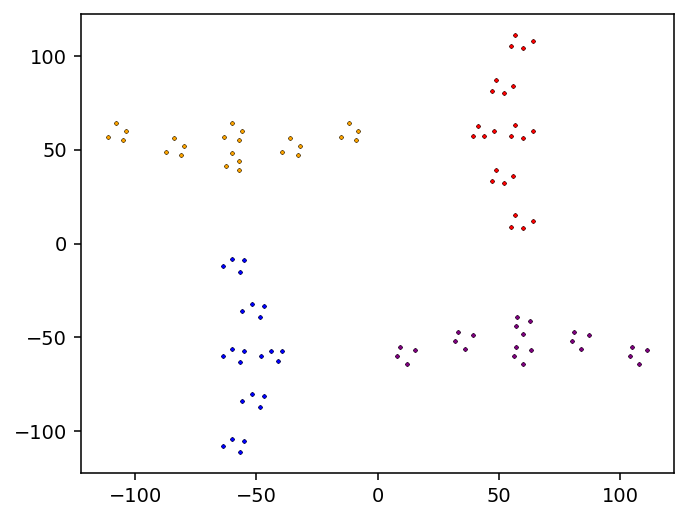

In [81]:

roomVentilationMI["orientation"] = pd.Series(dtype=float)

roomVentilationMI.loc[roomVentilationMI.blockType.isna(), "orientation"] = 0
roomVentilationMI.loc[roomVentilationMI.blockType == "Bx", "orientation"] = 90
roomVentilationMI.loc[roomVentilationMI.blockType == "Bxz", "orientation"] =180
roomVentilationMI.loc[roomVentilationMI.blockType == "Bz", "orientation"] = 270

fig, ax=plt.subplots(1, 1, constrained_layout =True)
ax.scatter(roomVentilationMI[roomVentilationMI["orientation"] ==   0]['x'], roomVentilationMI[roomVentilationMI["orientation"] ==   0]['z'], s=4*im_scaling, c="red", edgecolors="black", linewidths=.1)
ax.scatter(roomVentilationMI[roomVentilationMI["orientation"] ==  90]['x'], roomVentilationMI[roomVentilationMI["orientation"] ==  90]['z'], s=4*im_scaling, c="orange", edgecolors="black", linewidths=.1)
ax.scatter(roomVentilationMI[roomVentilationMI["orientation"] == 180]['x'], roomVentilationMI[roomVentilationMI["orientation"] == 180]['z'], s=4*im_scaling, c="blue", edgecolors="black", linewidths=.1)
ax.scatter(roomVentilationMI[roomVentilationMI["orientation"] == 270]['x'], roomVentilationMI[roomVentilationMI["orientation"] == 270]['z'], s=4*im_scaling, c="purple", edgecolors="black", linewidths=.1)
# plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rmsInterior', bbox_inches="tight")

In [110]:
def fillInParams(df):
    AofA = pd.Series(index = df.index, dtype = float)
    WS = pd.Series(index = df.index, dtype = float)
    Buoyancy = pd.Series(index = df.index, dtype = bool)
    Params = pd.Series(index = df.index, dtype = bool)
    for index, row in df.iterrows():
        run = index[0]
        angle = runs[run]["A"]
        AofA[index] = row["orientation"] + angle
        WS[index] = runs[run]["WS"]
        Buoyancy[index] = runs[run]["B"]
        if Buoyancy[index]:
            Params[index] = f"Wind Speed: {WS[index]} m/s; Buoyancy"
        else:
            Params[index] = f"Wind Speed: {WS[index]} m/s"
    df["AofA"] = AofA
    df["WS"] = WS
    df["B"] = Buoyancy
    df["Params"] = Params
    df["meanNorm"] = df["mean"] / df["WS"] * 4
    df["netNorm"] = df["mean"] / df["WS"] * 4
    df["rmsNorm"] = df["mean"] / df["WS"] * 4
    display(df)
    return df
flowStatsMI = fillInParams(flowStatsMI)
roomVentilationMI = fillInParams(roomVentilationMI)

/tmp/ipykernel_18188/2562241445.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Wind Speed: 4.0 m/s' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  Params[index] = f"Wind Speed: {WS[index]} m/s"


mean       rms       net    windowType openingType  \
15 xwindow_0-0_h_3-0   0.003392  0.099667  0.079093   xwindow_0-0     xwindow   
   zwindow_0-0_h_3-0  -0.003565  0.098751  0.078376   zwindow_0-0     zwindow   
   zwindow_2-0_h_3-0  -0.011747  0.091053  0.073916   zwindow_2-0     zwindow   
   zwindow_2-1_h_3-0   0.011283  0.091161  0.073875   zwindow_2-1     zwindow   
   xwindow_0-1_h_3-0   0.019779  0.091878  0.074038   xwindow_0-1     xwindow   
...                         ...       ...       ...           ...         ...   
24 xwindow_0-1_sl_Bz   0.068860  0.067176  0.080442   xwindow_0-1     xwindow   
   zwindow_0-1_sl_Bz   0.154485  0.064187  0.155015   zwindow_0-1     zwindow   
   zwindow_1-1_sl_Bz   0.055578  0.072836  0.072580   zwindow_1-1     zwindow   
   skylight_1-0_sl_Bz -0.007226  0.038859  0.029592  skylight_1-0    skylight   
   zwindow_1-0_sl_Bz   0.006940  0.038485  0.029093   zwindow_1-0     zwindow   

                      windowNumber houseType blockType      area          x  \
15 xwindow_0-0_h_3-0           0-0       3-0       NaN  0.562500  54.032272   
   zwindow_0-0_h_3-0           0-0       3-0       NaN  0.562500  56.000000   
   zwindow_2-0_h_3-0           2-0       3-0       NaN  0.562500  64.000000   
   zwindow_2-1_h_3-0           2-1       3-0       NaN  0.569530  64.000274   
   xwindow_0-1_h_3-0           0-1       3-0       NaN  0.562500  54.037566   
...                            ...       ...       ...       ...        ...   
24 xwindow_0-1_sl_Bz           0-1        sl        Bz  0.564852  61.999991   
   zwindow_0-1_sl_Bz           0-1        sl        Bz  0.563764  63.925112   
   zwindow_1-1_sl_Bz           1-1        sl        Bz  0.565068  63.924364   
   skylight_1-0_sl_Bz          1-0        sl        Bz  0.577597  58.007140   
   zwindow_1-0_sl_Bz           1-0        sl        Bz  0.563229  56.071573   

                       ...          z  roomType orientation   AofA   WS  \
15 xwindow_0-0_h_3-0   ...  10.000000    corner       180.0  180.0  4.0   
   zwindow_0-0_h_3-0   ...   8.044901    corner       270.0  270.0  4.0   
   zwindow_2-0_h_3-0   ...   8.045031     cross       270.0  270.0  4.0   
   zwindow_2-1_h_3-0   ...  15.893204     cross        90.0   90.0  4.0   
   xwindow_0-1_h_3-0   ...  14.000000      dual       180.0  180.0  4.0   
...                    ...        ...       ...         ...    ...  ...   
24 xwindow_0-1_sl_Bz   ... -37.999559      dual        90.0  135.0  2.0   
   zwindow_0-1_sl_Bz   ... -39.999613      dual         0.0   45.0  2.0   
   zwindow_1-1_sl_Bz   ... -44.001726      dual         0.0   45.0  2.0   
   skylight_1-0_sl_Bz  ... -44.000605    single         NaN    NaN  2.0   
   zwindow_1-0_sl_Bz   ... -44.000491    single       180.0  225.0  2.0   

                           B                         Params  meanNorm  \
15 xwindow_0-0_h_3-0   False            Wind Speed: 4.0 m/s  0.003392   
   zwindow_0-0_h_3-0   False            Wind Speed: 4.0 m/s -0.003565   
   zwindow_2-0_h_3-0   False            Wind Speed: 4.0 m/s -0.011747   
   zwindow_2-1_h_3-0   False            Wind Speed: 4.0 m/s  0.011283   
   xwindow_0-1_h_3-0   False            Wind Speed: 4.0 m/s  0.019779   
...                      ...                            ...       ...   
24 xwindow_0-1_sl_Bz    True  Wind Speed: 2.0 m/s; Buoyancy  0.137719   
   zwindow_0-1_sl_Bz    True  Wind Speed: 2.0 m/s; Buoyancy  0.308970   
   zwindow_1-1_sl_Bz    True  Wind Speed: 2.0 m/s; Buoyancy  0.111156   
   skylight_1-0_sl_Bz   True  Wind Speed: 2.0 m/s; Buoyancy -0.014453   
   zwindow_1-0_sl_Bz    True  Wind Speed: 2.0 m/s; Buoyancy  0.013880   

                        netNorm   rmsNorm  
15 xwindow_0-0_h_3-0   0.003392  0.003392  
   zwindow_0-0_h_3-0  -0.003565 -0.003565  
   zwindow_2-0_h_3-0  -0.011747 -0.011747  
   zwindow_2-1_h_3-0   0.011283  0.011283  
   xwindow_0-1_h_3-0   0.019779  0.019779  
...                         ...       ...  
24 xwindow_0-1_sl_B

/tmp/ipykernel_18188/2562241445.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Wind Speed: 4.0 m/s' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  Params[index] = f"Wind Speed: {WS[index]} m/s"


mean       net  contResid houseType blockType  \
15 corner_h_3-0     0.003479  0.078734  -0.000347       3-0       NaN   
   cross_h_3-0      0.011515  0.073896  -0.000927       3-0       NaN   
   dual_h_3-0       0.042457  0.100722  -0.000106       3-0       NaN   
   single_h_3-0     0.000217  0.001234  -0.000867       3-0       NaN   
   corner_h_3-1     0.011739  0.069984   0.000062       3-1       NaN   
...                      ...       ...        ...       ...       ...   
24 single_h_3-4_Bz  0.000318  0.000489   0.005095       3-4        Bz   
   corner_sl_Bz     0.167380  0.167946  -0.029205        sl        Bz   
   cross_sl_Bz      0.368436  0.377007   0.067233        sl        Bz   
   dual_sl_Bz       0.275201  0.290342   0.059552        sl        Bz   
   single_sl_Bz     0.007083  0.029343  -0.002293        sl        Bz   

                   roomType           x         y          z  orientation  \
15 corner_h_3-0      corner   55.016136  1.500000   9.022450          0.0   
   cross_h_3-0        cross   64.000137  1.498593  11.969118          0.0   
   dual_h_3-0          dual   56.678986  1.498136  15.262142          0.0   
   single_h_3-0      single   60.000000  1.500000   8.045070          0.0   
   corner_h_3-1      corner   47.015594  1.497615  33.055550          0.0   
...                     ...         ...       ...        ...          ...   
24 single_h_3-4_Bz   single  104.023340  1.499420 -59.997758        270.0   
   corner_sl_Bz      corner   57.358756  1.966833 -39.331883        270.0   
   cross_sl_Bz        cross   59.999651  2.203340 -48.000003        270.0   
   dual_sl_Bz          dual   62.769886  2.060568 -41.199981        270.0   
   single_sl_Bz      single   57.039356  2.197882 -44.000548        270.0   

                     AofA   WS      B                         Params  \
15 corner_h_3-0       0.0  4.0  False            Wind Speed: 4.0 m/s   
   cross_h_3-0        0.0  4.0  False            Wind Speed: 4.0 m/s   
   dual_h_3-0         0.0  4.0  False            Wind Speed: 4.0 m/s   
   single_h_3-0       0.0  4.0  False            Wind Speed: 4.0 m/s   
   corner_h_3-1       0.0  4.0  False            Wind Speed: 4.0 m/s   
...                   ...  ...    ...                            ...   
24 single_h_3-4_Bz  315.0  2.0   True  Wind Speed: 2.0 m/s; Buoyancy   
   corner_sl_Bz     315.0  2.0   True  Wind Speed: 2.0 m/s; Buoyancy   
   cross_sl_Bz      315.0  2.0   True  Wind Speed: 2.0 m/s; Buoyancy   
   dual_sl_Bz       315.0  2.0   True  Wind Speed: 2.0 m/s; Buoyancy   
   single_sl_Bz     315.0  2.0   True  Wind Speed: 2.0 m/s; Buoyancy   

                    meanNorm   netNorm   rmsNorm  
15 corner_h_3-0     0.003479  0.003479  0.003479  
   cross_h_3-0      0.011515  0.011515  0.011515  
   dual_h_3-0       0.042457  0.042457  0.042457  
   single_h_3-0     0.000217  0.000217  0.000217  
   corner_h_3-1     0.011739  0.011739  0.011739  
...                      ...       ...       ...  
24 single_h_3-4_Bz  0.000637  0.000637  0.000637  
   corner_sl_Bz     0.334761  0.334761  0.334761  
   cross_sl_Bz      0.736873  0.736873  0.736873  
   dual_sl_Bz       0.550401  0.550401  0.550401  
   single_sl_Bz     0.014166  0.014166  0.014166  

[672 rows x 17 columns]

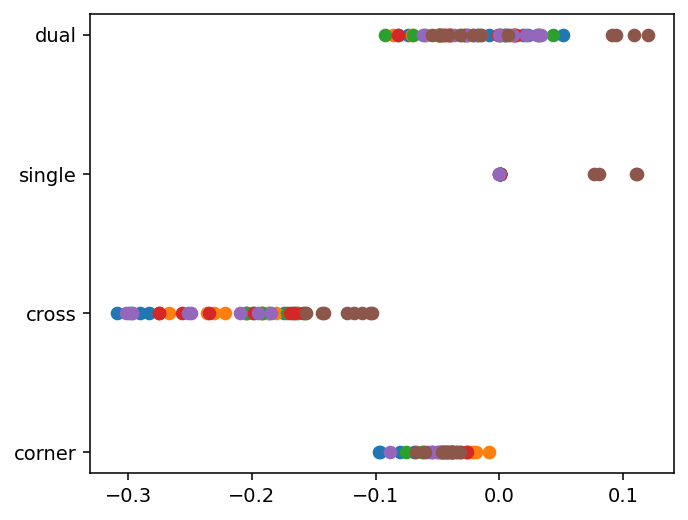

In [111]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
for houseType in set(flowStatsMI["houseType"]):
    plotdf = flowStatsMI[flowStatsMI["AofA"] == 0]
    plotdf = plotdf[plotdf["houseType"] == houseType]
    ax.scatter(plotdf["meanNorm"], plotdf["roomType"], label=Params)
# fig.legend()

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the swarmplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


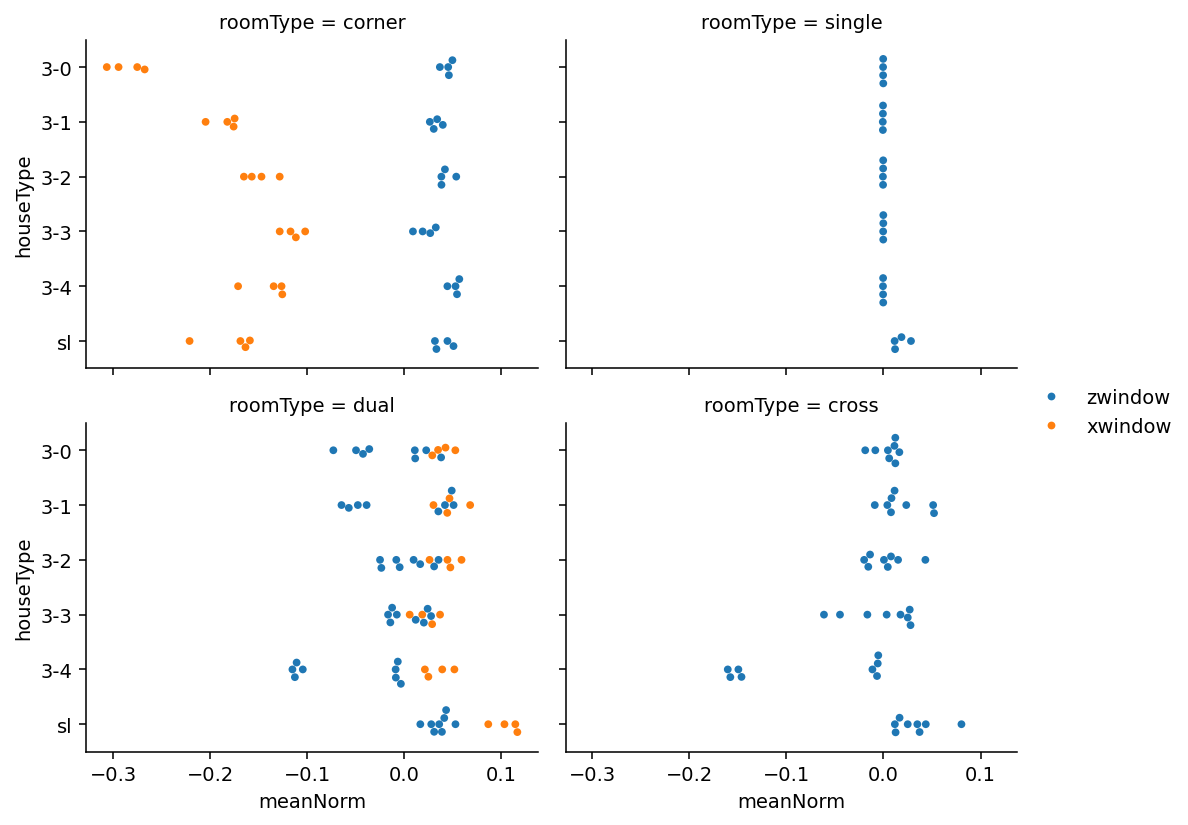

In [113]:
g = sns.FacetGrid(flowStatsMI[flowStatsMI["AofA"] == 90], col = "roomType", col_wrap = 2, col_order = ["corner", "single", "dual", "cross"], aspect = 1.25, legend_out = True)
# g.map(sns.violinplot, "meanNorm", "houseType", color = "1", inner = None, linewidth = 1, density_norm = "width", cut = 0)
# g.map(sns.boxplot, "net", "roomType", color = "1", linewidth = 1, fliersize = 0)
g.map(sns.swarmplot, "meanNorm", "houseType", "openingType", palette = "tab10", size = 4)
g.add_legend()

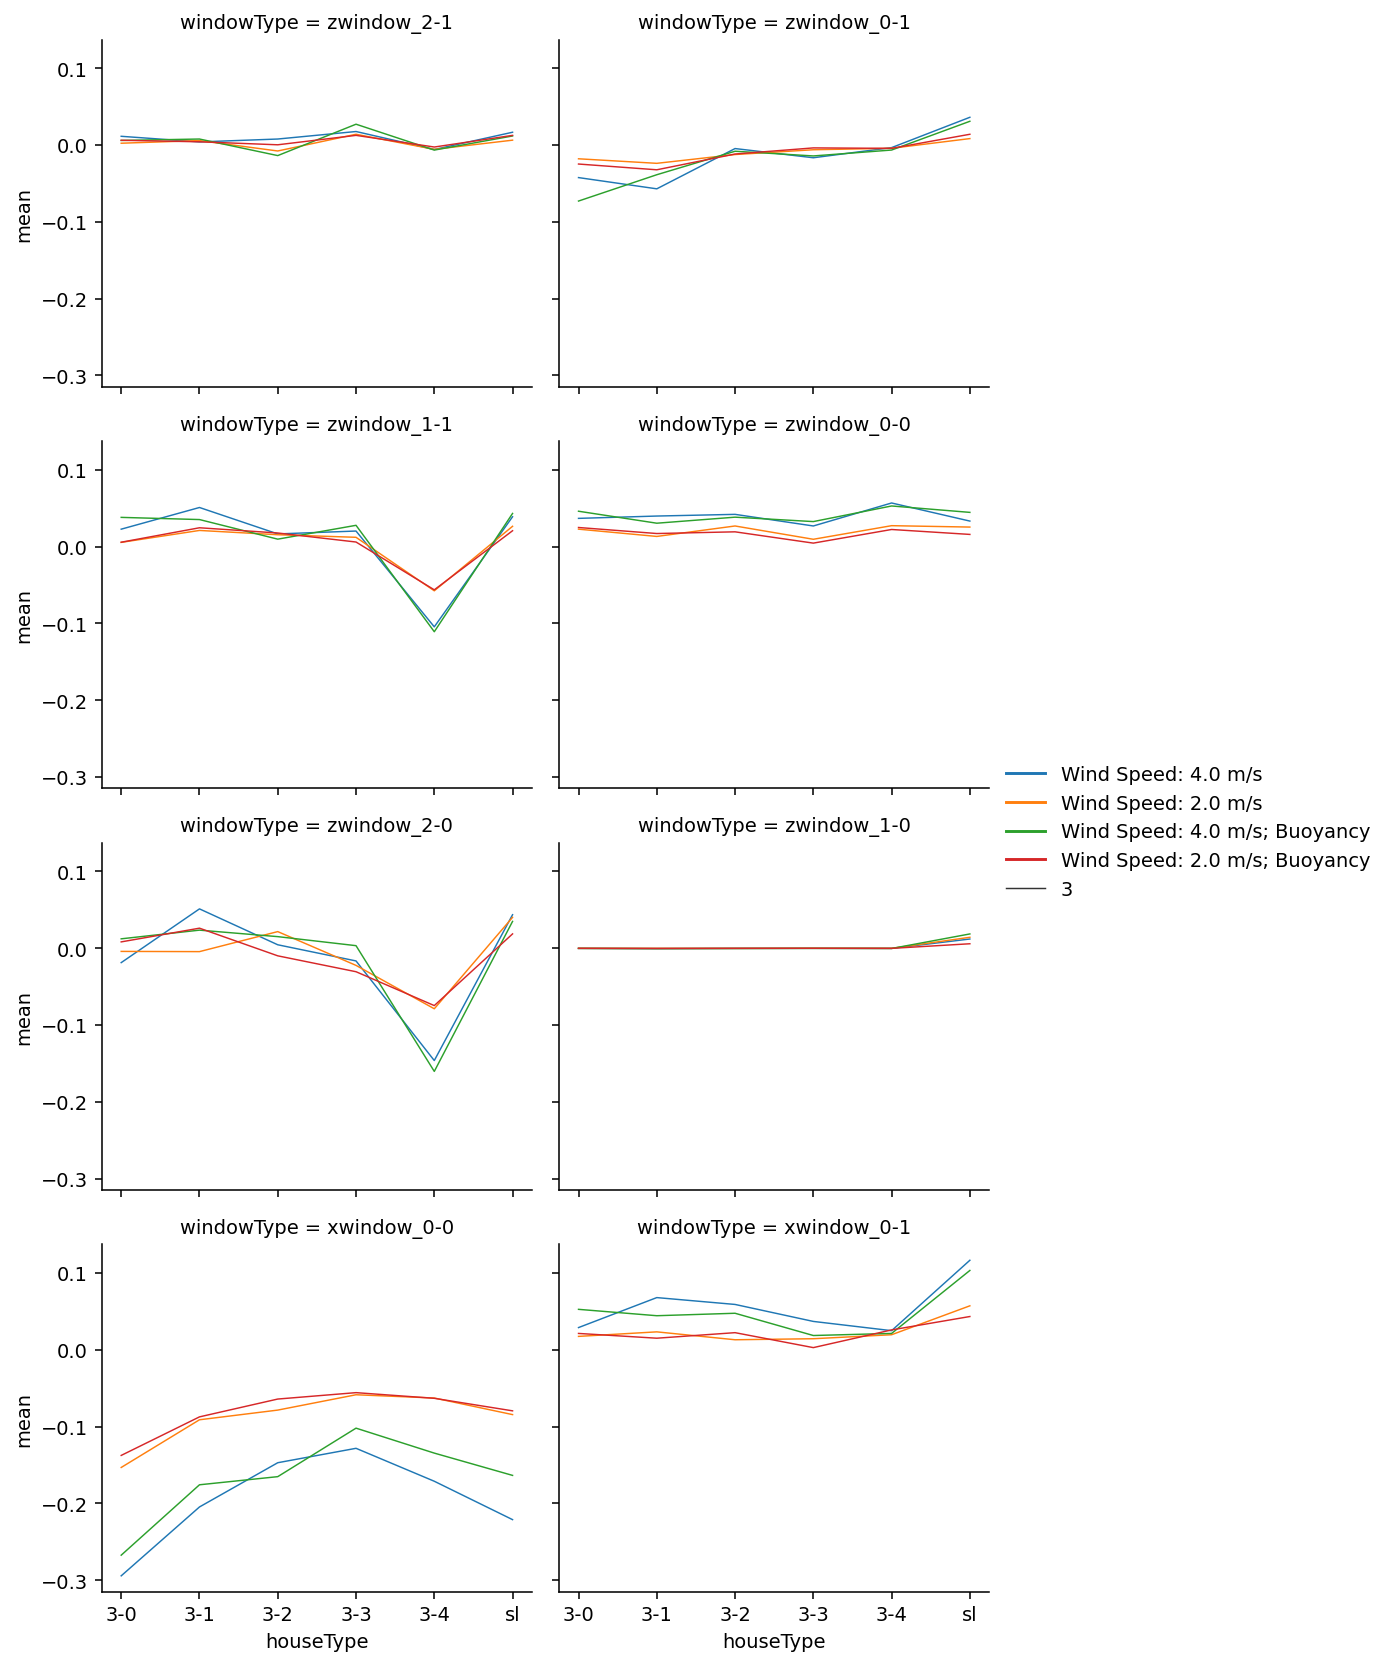

In [34]:
g = sns.FacetGrid(flowStatsMI[flowStatsMI["AofA"] == 90], col = "windowType", col_wrap = 2, aspect = 1.25, legend_out = True)
# g.map(sns.violinplot, "meanNorm", "houseType", color = "1", inner = None, linewidth = 1, density_norm = "width", cut = 0)
g.map(sns.lineplot, "houseType", "meanNorm", "Params", palette = "tab10", size = 3)
g.add_legend()

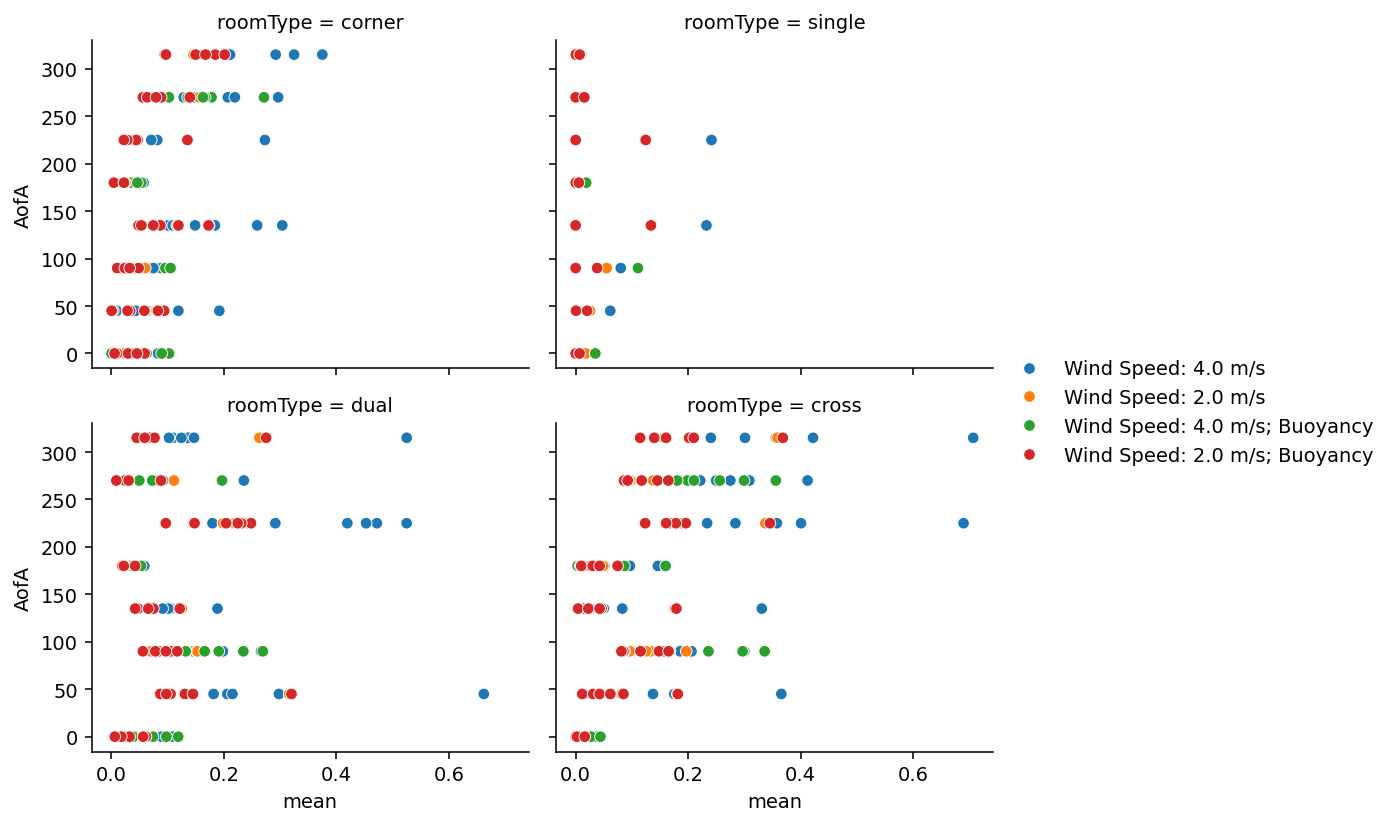

In [109]:
g = sns.FacetGrid(roomVentilationMI, col = "roomType", col_wrap = 2, col_order = ["corner", "single", "dual", "cross"], aspect = 1.25, legend_out = True)
# g.map(sns.violinplot, "net", "AofA", color = "1", inner = None, linewidth = 1, density_norm = "width", cut = 0)
g.map(sns.scatterplot, "mean", "AofA", "Params", palette = "tab10")
g.add_legend()

In [ ]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["mean"], cmap='seismic', edgecolors="black", linewidths=.1, norm=colors.CenteredNorm())
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["rms"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rmsInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["net"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["rms"]/flowStats["net"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rmsOnetInterior', bbox_inches="tight")

In [ ]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=4*im_scaling, c=roomVentilation["mean"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanRooms', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=4*im_scaling, c=roomVentilation["net"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netRooms', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=4*im_scaling, c=roomVentilation["contResid"], cmap='seismic', edgecolors="black", linewidths=.1, norm = colors.CenteredNorm())
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/residRooms', bbox_inches="tight")

In [ ]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im1=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=20, c=roomVentilation["mean"], cmap='binary', edgecolors="black", linewidths=.1, marker = 'X')
im2=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["mean"], cmap='seismic', edgecolors="black", linewidths=.1, norm = colors.CenteredNorm())
fig.colorbar(im1)
fig.colorbar(im2)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanWindowsRooms', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im1=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=20, c=roomVentilation["net"], cmap='binary', edgecolors="black", linewidths=.1, marker = 'X')
im2=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["net"], cmap='seismic', edgecolors="black", linewidths=.1, norm = colors.CenteredNorm())
fig.colorbar(im1)
fig.colorbar(im2)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netWindowsRooms', bbox_inches="tight")

In [ ]:
dfWindows = flowStats.loc[flowStats["openingType"].isin(["xwindow", "zwindow"])]

sns.lmplot(data = dfWindows, x = 'x', y = 'z', hue = 'houseType', fit_reg = False, palette = "tab10")
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/windowKeyLayout', bbox_inches="tight", dpi = 300)

g = sns.FacetGrid(dfWindows, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "net", "windowType", "roomType", inner = None, fill = False, palette = "Pastel1", linewidth = 1, density_norm = "width", cut = 0)
# g.map(sns.boxplot, "net", "windowType", color = "1", linewidth = 1, fliersize = 0)
g.map(sns.swarmplot, "net", "windowType", "houseType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netWindowViolins', bbox_inches="tight")

g = sns.FacetGrid(dfWindows, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "mean", "windowType", "roomType", inner = None, fill = False, palette = "Pastel1", linewidth = 1, density_norm = "width", cut = 0)
g.map(sns.swarmplot, "mean", "windowType", "houseType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanWindowViolins', bbox_inches="tight")

In [ ]:
sns.lmplot(data = roomVentilation, x = 'x', y = 'z', hue = 'houseType', fit_reg = False, palette = "tab10")
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/roomKeyLayout', bbox_inches="tight", dpi = 300)

g = sns.FacetGrid(roomVentilation, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "net", "roomType", color = "1", inner = None, linewidth = 1, density_norm = "width", cut = 0)
# g.map(sns.boxplot, "net", "roomType", color = "1", linewidth = 1, fliersize = 0)
g.map(sns.swarmplot, "net", "roomType", "houseType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netRoomViolins', bbox_inches="tight")

g = sns.FacetGrid(roomVentilation, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "mean", "roomType", color = "1", inner = None, linewidth = 1, density_norm = "width", cut = 0)
g.map(sns.swarmplot, "mean", "roomType", "houseType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanRoomViolins', bbox_inches="tight")

In [ ]:
g = sns.FacetGrid(roomVentilation, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.swarmplot, "net", "houseType", "roomType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netHouseByRoom', bbox_inches="tight")

g = sns.FacetGrid(roomVentilation, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.swarmplot, "mean", "houseType", "roomType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanHouseByRoom', bbox_inches="tight")

## Convergence

In [ ]:
data = probes.statistics(
    names = [name for name in probes.probe_names if "door" not in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [],
    parrallel=False
    )

In [ ]:
xPlot = data.index.values
yPlot = np.arange(len(data.keys()))

fig, ax=plt.subplots(1, 1, constrained_layout = True)
im=ax.scatter(flowStats.loc[data.keys(), 'x'], flowStats.loc[data.keys(), 'z'], s=4, c=yPlot, cmap='tab20c', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/dataMap', bbox_inches="tight")

In [ ]:
dataCumMean = probePost.cumulative_mean(data)

fig, ax = plt.subplots(constrained_layout = True)
im = ax.contourf(xPlot, yPlot, dataCumMean.abs().T, cmap = "inferno", levels=40)
fig.colorbar(im)
# ax.set_yticks(yPlot)
# ax.set_yticklabels(dataCumMean.keys())

plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourCumMean', bbox_inches="tight")

In [ ]:
dataConv = probePost.convergence(dataCumMean)

fig, ax = plt.subplots(constrained_layout = True)
im = ax.contourf(xPlot, yPlot, dataConv.abs().T, cmap = "inferno", levels=40)
fig.colorbar(im)

plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourConv', bbox_inches="tight")

In [ ]:
dataRevCumMean = probePost.reverse(data)
dataRevCumMean = probePost.cumulative_mean(dataRevCumMean)
dataRevCumMean = probePost.reverse(dataRevCumMean)

fig, ax = plt.subplots(constrained_layout = True)
im = ax.contourf(xPlot, yPlot, dataRevCumMean.abs().T, cmap = "inferno", levels=40, vmax = 1)
fig.colorbar(im)

plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourRevCumMean', bbox_inches="tight")

In [ ]:
@utils.no_kwargs
@utils.dict_apply
def sma(df): 
    return df.rolling(8000).mean()
    
dataSMA = sma(data)

fig, ax = plt.subplots(constrained_layout = True)
im = ax.contourf(xPlot, yPlot, dataSMA.abs().T, cmap = "inferno", levels=40)
fig.colorbar(im)

plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourSMA', bbox_inches="tight")